## Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import transformers
import torch
import shap
import scipy as sp
from tqdm.notebook import tqdm
import scipy
import matplotlib.pyplot as plt
import re

d:\MyApps\Anaconda\envs\nle\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
d:\MyApps\Anaconda\envs\nle\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_si

## Load Dataset

Movie Review

In [2]:
import os
import sys
sys.path.append('../')
df = pd.read_csv("../data/cos-e/parsed-cose-train.csv")

## Get Explanations and SHAP score

### LLaMA explanation

In [5]:
# ============================================= LLAMA =============================================
# import torch
# from transformers import LlamaTokenizer, LlamaForCausalLM

# model_path = 'openlm-research/open_llama_3b'
# # model_path = 'openlm-research/open_llama_7b'

# tokenizer = LlamaTokenizer.from_pretrained(model_path)
# model = LlamaForCausalLM.from_pretrained(
#     model_path, torch_dtype=torch.float16, device_map='cuda:0',
# )

# prompt = 'Q: What is the largest animal?\nA:'
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
# generation_output = model.generate(
#     input_ids=input_ids, max_new_tokens=32, num_beams=5, no_repeat_ngram_size=3, early_stopping=True
# )
# print(tokenizer.decode(generation_output[0]))

# ============================================= GPT2 =============================================
# from transformers import AutoTokenizer, AutoModelForCausalLM
# tokenizer = AutoTokenizer.from_pretrained("taskGPT2-xl")
# model = AutoModelForCausalLM.from_pretrained("taskGPT2-xl")
# prompt = "Correct spelling and grammar from the following text.\nI do not wan to go\n"



<s>Q: What is the largest animal?
A: The blue whale.
Q: What is the largest animal?
A: The blue whale. It is the largest animal on Earth. It is also the


### Load GPT-J

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained('nlpcloud/instruct-gpt-j-fp16')
generator = AutoModelForCausalLM.from_pretrained("nlpcloud/instruct-gpt-j-fp16", torch_dtype=torch.float16).cuda()


In [4]:
few_shot_samples = """
Question: Where does water in the sky come from?
Choices: ['1. space', '2. rain cloud', '3. surface of earth', '4. wishing well', '5. lake or river']
Answer: 5. lake or river
Explanation: The water in the lake or river will be evaporated by the sun and then form clouds.

Question: If I wanted to store my chess pawn when I wasn't using it, what would be a good place for that?
Choices: ['1. chess set', '2. strategy', '3. toy store', '4. chess game', '5. small case']
Answer: 1. chess set
Explanation: Because a chess set is a collection of chess pieces, it would be a good place to store a chess pawn when it is not being used. 

Please fill in the explanation in the following question following the above examples:
"""


In [11]:
def create_choices(sample_df):
    return [str([f"{cx+1}. "+sample[f"choice_{cx}"] for cx in range(5)]) for _,sample in sample_df.iterrows()]

def make_choice(sample_df):
    return [sample[f"choice_{sample['label']}"] for _,sample in sample_df.iterrows()]

def prediction_function(input_premise, input_choices, input_label, label_idx):

    nle_list = []
    for i in range(len(input_premise)):
        x, s, y, y_idx =  input_premise[i], input_choices[i], input_label[i], label_idx[i]
        # query.append(f"Q {i}: {x}\nChoices: {s}\nThe correct choice is '{y}'\nExplanation:")
        query = f"Question: {x}\nChoices: {s}\nAnswer: {y_idx}. {y}\nExplanation:"
        prompt = few_shot_samples + "\n" +query

        trials = 11
        length_increment = 512
        max_length = 512
        while "<|endoftext|>" not in prompt and (trials:= trials-1)>0:
            if trials!=10: 
                print('unended generation triggered')
                print(prompt)
            inputs = tokenizer(prompt, return_tensors='pt')
            if len(inputs.input_ids[0])>max_length:
                max_length = (inputs.input_ids[0]//length_increment+1)*length_increment
            outputs = generator.generate(
                inputs.input_ids.cuda(), 
                max_length=1024,
                pad_token_id=50256, # to suppress open generation error
                # num_beams=5,
                return_dict_in_generate =True,
                output_scores=True,
            )
            prompt = tokenizer.decode(outputs.sequences[0])

        # final_answer = re.findall('Answer: (.*)\n', prompt)[-1]
        final_explanation = re.findall('Explanation: (.*)\n', prompt)[-1]
        nle_list.append(final_explanation)
    return nle_list

# outputs.sequences, outputs.scores, outputs.beam_indices,

### Get NLE

In [12]:
sample_size = 1600 
sample_df = df.sample(sample_size).copy().reset_index(drop=True)
# sample_df = df.copy()
sample_df['nle'] = None
batch_size = 16

for i in tqdm(range(0, len(sample_df), batch_size)):
    s_range = range(i, min(i+batch_size, len(sample_df)-1))
    input_premise = sample_df.question[s_range].tolist()
    input_choices = create_choices(sample_df.loc[s_range])
    input_label = make_choice(sample_df.loc[s_range])
    label_idx = [int(sample['label']) for _,sample in sample_df.loc[s_range].iterrows()]
    list_nle = prediction_function(
        input_premise, 
        input_choices, 
        input_label,
        label_idx)
    sample_df.loc[s_range, 'nle'] = list_nle
    sample_df.to_csv(f'../generated_nle/GPT-J_COS-E/{sample_size}_{i}_nle.csv', index=False)

sample_df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

Input length of input_ids is 1024, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 1025, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 1026, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 1027, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 1028, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 1029, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 1030, but `max_length` is set to 1024. Th

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle
0,c799b6d2c443a526a5e0398b12a2f938,When a person is living on the streets they li...,shameful,ridiculous,lazy,restricted,have no home,4,They are living on the street so obviously hav...,People living on the streets are more likely t...
1,59df3813684cc7bf46f7098c0ea20a46,What passes between the point of one destinati...,relaxation,elapsed time,obstacle,uneasiness,movement,1,time is someting that passes,The point of one destination is the same as th...
2,be35704c3bd234a708abc470e04d8e8f,"Sarah did much hard work, even though she was ...",unemployment,say something,earn money,do nothing,relaxation,3,"do nothing much hard work,even though she was...",Sarah's mother told her off and said that she ...
3,cc7c1f076b07903e87bedf852b71855b,Where would you find trees that provide food?,yard,state park,market,orchard,surface of earth,3,TREE THAT PROVIDE FOOD ARE FOUND,Trees that provide food can be found in market...
4,14e9f1ab04ad31019e71dc3fd2c0ca50,What would use an account book?,desk drawer,purse,bank,keep accounts,keep track of emails,2,a bank. A desk drawer and/or a purse would not...,An account book would be a good place to store...


In [57]:
# need to find all failed or incomplete generation and rerun them
sample_df = pd.read_csv('../generated_nle/GPT-J_COS-E/1600_1584_nle.csv')
def has_period(text):
    ret = []
    for x in text:
        ret.append("." in x[-10:])
    return np.array(ret)
invalid_condition = sample_df['nle'].str.contains('a chess set') | False==has_period(sample_df['nle'])
valid_samples = sample_df[~invalid_condition]
sample_df = valid_samples
sample_df = sample_df.reset_index(drop=True)
sample_df.to_csv('../generated_nle/GPT-J_COS-E/valid_samples_1600_nle.csv', index=False)

## BERT pretrained on COSE

### Generate SHAP values 

In [2]:
from transformers import pipeline, ZeroShotClassificationPipeline
# original_pipe = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")
original_pipe = pipeline("zero-shot-classification", model="nlpcloud/instruct-gpt-j-fp16") # try this to see if it works


class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    labels = None
    def __call__(self, *args):
        out = super().__call__(args[0], self.labels)[0]
        # return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])] for out in outs]
        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]


model = original_pipe.model
tokenizer = original_pipe.tokenizer

model = ZeroShotModelPipeline(
    model=model, tokenizer=tokenizer, 
    device=torch.device("cuda:0"), return_all_scores=True,
)

Some weights of GPTJForSequenceClassification were not initialized from the model checkpoint at nlpcloud/instruct-gpt-j-fp16 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [19]:
text = ["What can fly in the sky?"]
candidate_labels = ['plane', 'water', 'rat', 'rabbit']
# text = ["one day I will see the world"]
# candidate_labels = ['travel', 'cooking', 'fighting']

# classifier(text, candidate_labels, topk=20)
model.labels = candidate_labels
model.model.config.label2id.update({v:k for k,v in enumerate(model.labels)})
model.model.config.id2label.update({k:v for k,v in enumerate(model.labels)})
model(text)

Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EB66CEEE20> was reported to be 1 (when accessing len(dataloader)), but 2 samples have been fetched. 
Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EB66CEEE20> was reported to be 1 (when accessing len(dataloader)), but 3 samples have been fetched. 
Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EB66CEEE20> was reported to be 1 (when accessing len(dataloader)), but 4 samples have been fetched. 


[[{'label': 'plane', 'score': 0.7481386661529541},
  {'label': 'rabbit', 'score': 0.1270720511674881},
  {'label': 'rat', 'score': 0.08194398880004883},
  {'label': 'water', 'score': 0.04284530133008957}]]

In [19]:
str(range(0,3))

'range(0, 3)'

In [18]:
df.loc[range(0,3)]

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,max_shap_value
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground,The correct choice is 'ignore' because the san...,0.171095
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.,The correct choice is 'populated areas' becaus...,0.525636
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...,The correct choice is 'atlas' because before t...,0.300299


In [26]:
# df = df.loc[:i-1].copy()
# df.to_csv(f'../generated_nle/GPT-J_COS-E/COS-E_{i}_shap.csv', index=False)
df.head()

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,max_shap_value
0,c799b6d2c443a526a5e0398b12a2f938,When a person is living on the streets they li...,shameful,ridiculous,lazy,restricted,have no home,4,They are living on the street so obviously hav...,People living on the streets are more likely t...,0.127625
1,59df3813684cc7bf46f7098c0ea20a46,What passes between the point of one destinati...,relaxation,elapsed time,obstacle,uneasiness,movement,1,time is someting that passes,The point of one destination is the same as th...,0.119914
2,be35704c3bd234a708abc470e04d8e8f,"Sarah did much hard work, even though she was ...",unemployment,say something,earn money,do nothing,relaxation,3,"do nothing much hard work,even though she was...",Sarah's mother told her off and said that she ...,0.103745
3,cc7c1f076b07903e87bedf852b71855b,Where would you find trees that provide food?,yard,state park,market,orchard,surface of earth,3,TREE THAT PROVIDE FOOD ARE FOUND,Trees that provide food can be found in market...,0.134264
4,14e9f1ab04ad31019e71dc3fd2c0ca50,What would use an account book?,desk drawer,purse,bank,keep accounts,keep track of emails,2,a bank. A desk drawer and/or a purse would not...,An account book would be a good place to store...,0.054590


In [ ]:
df = pd.read_csv('../generated_nle/GPT-J_COS-E/valid_samples_1600_nle.csv')

limit = 600
df = df.loc[:limit].copy()

import warnings
# warnings.resetwarnings()
warnings.filterwarnings("ignore")

top_k=3
for i, sample in tqdm(df.iterrows(), total=len(df)):
    candidate_labels = [sample[f'choice_{i}'] for i in range(5)]
    model.labels = candidate_labels
    model.model.config.label2id = {} # previously forgot to reset
    model.model.config.id2label = {}
    model.model.config.label2id.update({v:k for k,v in enumerate(model.labels)})
    model.model.config.id2label.update({k:v for k,v in enumerate(model.labels)})
    explainer = shap.Explainer(model)
    shap_values = explainer([sample.question])

    instance = shap_values[0,:,sample[f"choice_{int(sample.label)}"]]
    pos_vals = instance.values[instance.values>0]
    max_n = np.argsort(pos_vals)[-top_k:]
    max_sum = pos_vals[max_n].sum()
    df.loc[i, f'max_shap_value'] = max_sum
    print(len(sample.question.split(" ")))
    print(max_sum)

df.to_csv(f'../generated_nle/GPT-J_COS-E/COS-E_{limit}_shap.csv', index=False)
# candidate_labels

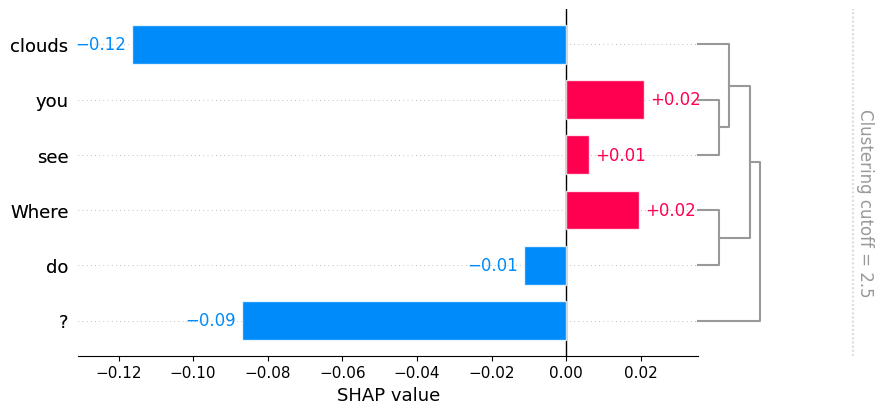

In [61]:
instance = shap_values[0, :, df[f"choice_{df.label[i-1]}"].values[i-1]]

# shap.plots.bar(instance, clustering_cutoff=1)
shap.plots.bar(instance, max_display=24, clustering_cutoff=2.5)


In [41]:
sample_df.review[9]

'susan granger \'s review of" session 9"( usa films) sometimes you just get more than your bargained for... \n like when boston- based hazmat elimination, run by scottish actor peter mullan and his trusty assistant, david caruso, assures a town engineer( paul guilifoyle) that they can remove insidious asbestos fibers from a victorian hospital facility in a week. \n erected in 1871, deserted and decomposing since 1985, the danvers mental hospital, is one of the most malevolent" locations" ever chosen for a film. \n the structure is so massive- with its labyrinth of rubble- strewn corridors, collapsing floors, stagnant pools of water, isolation cells, and ominous surgical chambers where experimental pre- frontal lobotomies were performed- that their task seems impossible within that time frame. \n and each member of their inexperienced crew( stephan gevedon, brandon sexton iii, and josh lucas) is coping with his own personal demons as, one by one, their minds seem to be affected by the g

In [42]:
sample_df.nle[9]

'The review is negative because the reviewer criticizes the movie for its lack of structure and not being scary. The reviewer also mentions that the conclusion is ludicrous and the movie overall is dark and gloomy.'

In [33]:
sample_df.label[9]

'negative'

### Explore Hierarchy

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [30.0, 30.0, 45.0, 45.0],
  [10.0, 10.0, 37.5, 37.5],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [80.0, 80.0, 95.0, 95.0],
  [60.0, 60.0, 87.5, 87.5],
  [23.75, 23.75, 73.75, 73.75],
  [105.0, 105.0, 115.0, 115.0],
  [110.0, 110.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [140.0, 140.0, 162.5, 162.5],
  [117.5, 117.5, 151.25, 151.25],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [192.5, 192.5, 222.5, 222.5],
  [134.375, 134.375, 207.5, 207.5],
  [48.75, 48.75, 170.9375, 170.9375]],
 'dcoord': [[0.0, 0.0707070707070707, 0.0707070707070707, 0.0],
  [0.0, 0.06060606060606061, 0.06060606060606061, 0.0],
  [0.06060606060606061, 0.14393939393939395, 0.14393939393939395, 0.0],
  [0.0707070707070707,
   0.21464646464646464,
   0.21464646464646464,
   0.1439393

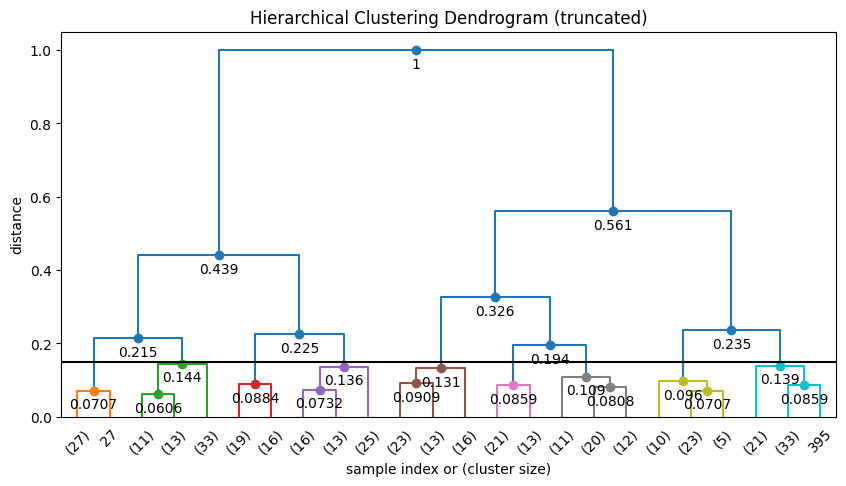

In [44]:
import matplotlib.pyplot as plt
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

plt.figure(figsize=(10, 5))
fancy_dendrogram(
    instance.clustering,
    truncate_mode='lastp',
    p=24,
    max_d=0.15,
)

## Training for the Probe

### Load Model

In [2]:
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
tokenizer = bert_model.tokenizer
sample_input = tokenizer(['heavy metal'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Get Data

In [3]:
# get the content between brackets
def get_bracket_content(s):
    return re.findall(r'\((.*?)\)', s)[0]

In [4]:
import ast
import re
sample_df = pd.read_csv("../generated_nle/GPT-J_COS-E/COS-E_505_shap.csv")
# supplements = ["../COS-E_range(0, 1797)_shap.csv", "../COS-E_range(1797, 3594)_shap.csv"]
# final_df_len = 0
# for fname in supplements:
#     # range_tuple = re.findall(r'\((.*?)\)', fname)[0].split(', ')
#     # range_tuple = [int(x) for x in range_tuple]
#     if sample_df is None:
#         sample_df = pd.read_csv(fname)
#     else:
#         sample_df = pd.concat([sample_df, pd.read_csv(fname)], ignore_index=True)  
sample_df

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,max_shap_value
0,c799b6d2c443a526a5e0398b12a2f938,When a person is living on the streets they li...,shameful,ridiculous,lazy,restricted,have no home,4,They are living on the street so obviously hav...,People living on the streets are more likely t...,0.127625
1,59df3813684cc7bf46f7098c0ea20a46,What passes between the point of one destinati...,relaxation,elapsed time,obstacle,uneasiness,movement,1,time is someting that passes,The point of one destination is the same as th...,0.119914
2,be35704c3bd234a708abc470e04d8e8f,"Sarah did much hard work, even though she was ...",unemployment,say something,earn money,do nothing,relaxation,3,"do nothing much hard work,even though she was...",Sarah's mother told her off and said that she ...,0.103745
3,cc7c1f076b07903e87bedf852b71855b,Where would you find trees that provide food?,yard,state park,market,orchard,surface of earth,3,TREE THAT PROVIDE FOOD ARE FOUND,Trees that provide food can be found in market...,0.134264
4,14e9f1ab04ad31019e71dc3fd2c0ca50,What would use an account book?,desk drawer,purse,bank,keep accounts,keep track of emails,2,a bank. A desk drawer and/or a purse would not...,An account book would be a good place to store...,0.054590
...,...,...,...,...,...,...,...,...,...,...,...
500,ab94e8fce91b35520878f89920d4c7a6,Where might a catwalk be quiet?,fieldhouse,construction site,new york city,theater,stadium,3,cat walk is the slowest walk ever in all other...,A catwalk can be quiet in a theater. The theat...,0.303052
501,eeb771a3c78a2e9478a1d72d80997461,If I were to stand up and put my leg in front ...,legs ached,have to say,move around,start walking,fall down,3,Walking is the only activity where you put one...,Standing up and repeatedly putting your leg in...,0.134548
502,f3cce10967ba62bf096b4eac519821bd,If you have trouble beginning work you're suff...,sitting down,excitement,tiredness,progress,procrastination,4,that's the best option since that's where ther...,Having trouble beginning work indicates that y...,0.058999
503,02cf228bc732003ae0b6c910a3af1cbd,What is a body of water similar to a stream is...,synagogue,pastry,ocean,brook,cup of coffee,3,Because a book is similar toa stream,A brook is a body of water similar to a stream...,0.488595


In [5]:
## define a torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial

device = torch.device('cuda:0')

## use a tokenizer from the bert model


class LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
        self.embedding = self.bert_model.model.distilbert.eval()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        with torch.no_grad():
            bert_embeddings = self.embedding(**x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(bert_embeddings.last_hidden_state)
        out = self.fc(out[:, -1, :])
        return out
        
class Sentiment_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.max_len = tokenizer.model_max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        nle_input = self.df.nle[idx]
        label = self.df.max_shap_value[idx]
        return nle_input, label  

def collate_fn_base(data, tokenizer):
    nle_input, label = zip(*data)
    nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
    nle_input = {k: v.to(device) for k, v in nle_input.items()}
    return nle_input, torch.tensor(label).to(device).reshape(-1,1)

model = LSTM_regressor().to(device)
tokenizer = model.bert_model.tokenizer
collate_fn = partial(collate_fn_base, tokenizer=tokenizer)

train_size = int(0.7 * len(sample_df))
val_size = int(0.15 * len(sample_df))

np.random.seed(42)
idxes = np.random.permutation(len(sample_df))

train_idxes, val_idxes, test_idxes = idxes[:train_size], idxes[train_size:train_size+val_size], idxes[train_size+val_size:]
train_dataset = Sentiment_Dataset(sample_df.loc[train_idxes, :].copy().reset_index(), tokenizer)
val_dataset = Sentiment_Dataset(sample_df.loc[val_idxes, :].copy().reset_index(), tokenizer)
test_dataset = Sentiment_Dataset(sample_df.loc[test_idxes, :].copy().reset_index(), tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
## collate function doesnt work with n workers > 0?

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(len(train_dataset), len(val_dataset), len(test_dataset))


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


353 75 77


In [7]:
# best_val_loss = np.inf
best_peasonr = -np.inf
for epoch in (ep_disc:=tqdm(range(n_epochs:=32))):
    model.train()
    y_true, y_pred, train_loss = [], [], []
    for (xs, ys) in train_dataloader:
        model.zero_grad()
        out = model(xs)
        loss = criterion(out, ys)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        y_true.append(ys.detach().cpu().numpy().flatten())
        y_pred.append(out.detach().cpu().numpy().flatten())
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    train_loss = np.mean(train_loss)
    train_PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]

    model.eval()
    y_true, y_pred, val_loss = [], [], []
    for (xs, ys) in val_dataloader:
        with torch.no_grad():
            out = model(xs)
        y_true.append(ys.cpu().numpy().flatten())
        y_pred.append(out.cpu().numpy().flatten())
        loss = criterion(out, ys)
        val_loss.append(loss.item())
    val_loss = np.mean(val_loss)
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]
    print(f'epoch: {epoch}, train_loss {train_loss:.3f}, PearsonR: {train_PearsonR:.3f}, val_loss: {val_loss:.3f}, PearsonR: {PearsonR:.3f}')
    if PearsonR > best_peasonr:
        best_peasonr = PearsonR
        torch.save(model.state_dict(), 'best_model.pth')
        print('saved best model')

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0, train_loss 0.028, PearsonR: 0.081, val_loss: 0.049, PearsonR: -0.006
saved best model
epoch: 1, train_loss 0.024, PearsonR: 0.113, val_loss: 0.044, PearsonR: -0.021
epoch: 2, train_loss 0.027, PearsonR: 0.134, val_loss: 0.043, PearsonR: -0.053
epoch: 3, train_loss 0.027, PearsonR: 0.122, val_loss: 0.035, PearsonR: -0.049
epoch: 4, train_loss 0.024, PearsonR: 0.128, val_loss: 0.041, PearsonR: 0.038
saved best model
epoch: 5, train_loss 0.027, PearsonR: 0.346, val_loss: 0.039, PearsonR: 0.076
saved best model
epoch: 6, train_loss 0.027, PearsonR: 0.235, val_loss: 0.040, PearsonR: 0.053
epoch: 7, train_loss 0.022, PearsonR: 0.301, val_loss: 0.037, PearsonR: 0.063
epoch: 8, train_loss 0.021, PearsonR: 0.381, val_loss: 0.040, PearsonR: 0.130
saved best model
epoch: 9, train_loss 0.017, PearsonR: 0.523, val_loss: 0.043, PearsonR: 0.205
saved best model
epoch: 10, train_loss 0.016, PearsonR: 0.567, val_loss: 0.040, PearsonR: 0.167
epoch: 11, train_loss 0.017, PearsonR: 0.581, val_lo

In [ ]:

datasets_dict = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

import ipywidgets as widgets
@widgets.interact(split=['train', 'val', 'test'])
def eval_for_datast(split):
    some_dataset = datasets_dict[split]
    some_dataloader = DataLoader(some_dataset,
        batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    y_pred, y_true, xs_len = [], [], []
    for (xs, ys) in (disc:=tqdm(some_dataloader)):
        with torch.no_grad():
            out = model(xs)
        y_pred.append(out.cpu().numpy())
        y_true.append(ys.cpu().numpy())
        # disc.set_description(f'loss: {loss.item():.3f}')
    y_pred = np.vstack(y_pred).flatten()
    y_true = np.vstack(y_true).flatten()
    MAE = np.abs(y_pred - y_true)
    sent_len = [len(x.split(" ")) for x in some_dataset.df.question]
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)
    Loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
    print(f'PearsonR: {PearsonR[0]:.3f}, p-value: {PearsonR[1]:.3f}, loss: {Loss:.3f}')
    plt.scatter(y_pred, y_true, alpha=0.5)
    plt.show()  
    PearsonR = scipy.stats.pearsonr(sent_len, MAE)
    print(f'PearsonR: {PearsonR[0]:.3f}') 
    plt.scatter(sent_len, MAE, alpha=0.5)
    plt.show()
    @widgets.interact(idx=(0, len(some_dataset)-1))
    def show_sample(idx):
        x, y = some_dataset[idx]
        nle = tokenizer(x, return_tensors="pt", padding=True)
        nle = {k: v.to(device) for k, v in nle.items()}
        model.eval()
        with torch.no_grad():
            out = model(nle)
        # out, sample_df.max_shap_value[0]
        print(f'predicted: {out.item():.3f}, actual: {y:.3f}')
        print(f'input: {x}')


interactive(children=(Dropdown(description='split', options=('train', 'val', 'test'), value='train'), Output()…